In [26]:
import numpy as np
from numpy import ndarray
from typing import Dict, Tuple

In [27]:
def linear_regression_forward(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]) -> Tuple[float, Dict[str, ndarray]]:
    # input dimensions
    assert X_batch.shape[0] == y_batch.shape[0]
    assert X_batch.shape[1] == weights['W'].shape[0]
    assert weights['B'].shape[0] == weights['B'].shape[1]
    
    # forward pass
    N = np.dot(X_batch, weights['W'])
    P = N + weights['B']
    
    # calculate loss
    # method 1
    loss = np.mean(np.power(y_batch - P, 2))
    # method 2
    # loss = np.sum(np.power(y_batch - P, 2))/(2*len(X_batch))
    
    # save forward pass info
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['P'] = P
    forward_info['N'] = N 
    forward_info['y'] = y_batch
    
    return  forward_info, loss

In [28]:
X = np.array([
    [0,2],
    [2,5],
    [3,4]
     ])

y = np.array([
    [0],
    [1],
    [1]
     ])

w = {
    'W': np.array([
        [0.2],
        [0.1]
        ]),
    'B': np.array([[0.1]])
}

forward_info, loss = linear_regression_forward(X, y, w)
print('Loss: ', loss)
print('Forward Pass: ');display(forward_info)

Loss:  0.03333333333333335
Forward Pass: 


{'X': array([[0, 2],
        [2, 5],
        [3, 4]]),
 'P': array([[0.3],
        [1. ],
        [1.1]]),
 'N': array([[0.2],
        [0.9],
        [1. ]]),
 'y': array([[0],
        [1],
        [1]])}

In [29]:
def loss_gradients(forward_info: Dict[str, ndarray], weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    batch_size = forward_info['X'].shape[0] # number of samples
    
    # find grads: dLdB, dLdW
    
    # grad of loss wrt p -> using squared error: (y-P) ^ 2
    dLdP = -2 * (forward_info['y'] - forward_info['P'])/ batch_size # dividing by batch_size to avoid exploding grads
    # for mean squared error, grad of loss wrt p -> using mean squared error: 1/2(y-P) ^ 2
    # dLdP = forward_info['P'] - forward_info['y'] / batch_size
    
    # intermediate derivatives
    dPdN = np.ones_like(forward_info['N'])
    dPdB = np.ones_like(weights['B'])
    dLdN = dLdP * dPdN 
    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # final derivatives of w, b
    dLdW = np.dot(dNdW, dLdN)
    dLdB = (dLdP * dPdB).sum(axis=0, keepdims=True)
    
    # save the loss
    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB
    
    return loss_gradients

loss_grad = loss_gradients(forward_info, w)
display(loss_grad)

{'W': array([[0.2       ],
        [0.66666667]]),
 'B': array([[0.26666667]])}

In [30]:
# shuffling data with np.random.permutation(), makes a copy
n_samples = 5
# generate 10 different shuffled samples
for i in range(10):
    indices = np.random.permutation(n_samples)
    print(f'shuffled data with permutation {i+1}: ', indices)
    
# shuffling data with np.shuffle(), changes the original array
samples = np.array([4,1,9,3])
# generate 10 different shuffled samples
for i in range(10):
    np.random.shuffle(samples)
    print(f'shuffled data with shuffle {i+1}: ', samples)

shuffled data with permutation 1:  [4 0 2 1 3]
shuffled data with permutation 2:  [2 1 0 4 3]
shuffled data with permutation 3:  [2 0 4 1 3]
shuffled data with permutation 4:  [1 4 2 3 0]
shuffled data with permutation 5:  [0 4 2 1 3]
shuffled data with permutation 6:  [2 3 0 1 4]
shuffled data with permutation 7:  [1 2 4 3 0]
shuffled data with permutation 8:  [3 2 0 4 1]
shuffled data with permutation 9:  [0 2 4 3 1]
shuffled data with permutation 10:  [1 2 4 3 0]
shuffled data with shuffle 1:  [1 9 3 4]
shuffled data with shuffle 2:  [9 1 3 4]
shuffled data with shuffle 3:  [4 3 9 1]
shuffled data with shuffle 4:  [4 1 3 9]
shuffled data with shuffle 5:  [9 1 4 3]
shuffled data with shuffle 6:  [4 1 3 9]
shuffled data with shuffle 7:  [1 3 4 9]
shuffled data with shuffle 8:  [9 4 3 1]
shuffled data with shuffle 9:  [3 1 9 4]
shuffled data with shuffle 10:  [3 9 1 4]


In [31]:
# train model
def train(X_train: ndarray, y_train: ndarray, learning_rate: float, batch_size: int=23, epochs: int=100, return_weights: bool=False, seed: int = None)-> Dict:
    
    # set random seed
    if seed is not None:
        np.random.seed(seed)
        
    # initialize features
    n_features = X_train.shape[1]
    weights = {
        # w -> small random numbers
        'W': np.random.randn(n_features, 1) * 0.1 , # reproducible numbers
        # b -> all zeros 
        'B': np.zeros((1,1))
    }
    
    # track progress 
    losses = []
    n_samples = X_train.shape[0]
    
    for epoch in range(epochs):
        epoch_losses = []
        # shuffling the data for each loop 
        shuffled_indices = np.random.permutation(n_samples)
        # shuffles both samples and the targets with same indices
        X_shuffled = X_train[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]
        
        # processing the mini batches
        # starts at 0, ends at n_samples, step by batch_size
        for i in range(0, n_samples, batch_size):
            # taking min to prevent end index going beyond the samples end
            end_index = min(i + batch_size, n_samples)
            # range a mini batch from i to end_index
            X_batch = X_shuffled[i: end_index]
            y_batch = y_shuffled[i: end_index]
            
            # forward pass , making predictions, given mini batches and weights
            forward_info, loss = linear_regression_forward(X_batch, y_batch, weights)
            
            # save the losses of current epoch
            epoch_losses.append(loss)
            
            # backward pass , compute grads from the calculated loss, returns a dictionary of losses
            loss_grads = loss_gradients(forward_info, weights)
            
            # update weights, w and b
            for key in weights.keys():
                # key is same for w,b and loss_grads in both dictionaries -> weights and loss_grads
                weights[key] -= learning_rate * loss_grads[key]
            
        # calculate average loss of current epoch
        average_epoch_loss = np.mean(epoch_losses)
        # append current epoch loss average to losses list
        losses.append(average_epoch_loss)
        
        # print progress
        print(f'epoch: {epoch+1} - epoch average loss: {average_epoch_loss:.5f}')

    # save model training info 
    train_info = {
        'losses': losses,
        'initial_loss': losses[0],
        'final_loss': losses[-1],
        'total epochs': epochs,
        'learning rate': learning_rate,
        'batch_size': batch_size
    }

    if return_weights:
        train_info['weights'] = weights
    
    return train_info

In [36]:
X_train = np.array([
        [0, 2], [2, 5], [3, 4], [1, 3], [4, 1],
        [2, 2], [3, 3], [1, 4], [4, 2], [0, 1]
    ])
    
y_train = np.array([
        [0], [1], [1], [0.5], [0.8],
        [0.6], [0.9], [0.7], [0.9], [0.1]
    ])
    
train_info = train(X_train, y_train, learning_rate=0.01, batch_size=len(X_train), epochs=100, return_weights=True, seed=42)
    
print("\nTraining completed!")
print(f"Initial loss: {train_info['initial_loss']:.4f}, Final loss: {train_info['final_loss']:.4f}")
    
if 'weights' in train_info:
    print("Final weights:")
    for key, value in train_info['weights'].items():
        print(f"{key}: {value.tolist()}")

epoch: 1 - epoch average loss: 0.43323
epoch: 2 - epoch average loss: 0.23005
epoch: 3 - epoch average loss: 0.12418
epoch: 4 - epoch average loss: 0.06901
epoch: 5 - epoch average loss: 0.04023
epoch: 6 - epoch average loss: 0.02521
epoch: 7 - epoch average loss: 0.01735
epoch: 8 - epoch average loss: 0.01322
epoch: 9 - epoch average loss: 0.01105
epoch: 10 - epoch average loss: 0.00988
epoch: 11 - epoch average loss: 0.00925
epoch: 12 - epoch average loss: 0.00890
epoch: 13 - epoch average loss: 0.00869
epoch: 14 - epoch average loss: 0.00855
epoch: 15 - epoch average loss: 0.00846
epoch: 16 - epoch average loss: 0.00840
epoch: 17 - epoch average loss: 0.00834
epoch: 18 - epoch average loss: 0.00829
epoch: 19 - epoch average loss: 0.00825
epoch: 20 - epoch average loss: 0.00821
epoch: 21 - epoch average loss: 0.00817
epoch: 22 - epoch average loss: 0.00813
epoch: 23 - epoch average loss: 0.00810
epoch: 24 - epoch average loss: 0.00806
epoch: 25 - epoch average loss: 0.00803
epoch: 26

In [37]:
# predictions with final weights
weights = train_info['weights']
W, B = weights['W'], weights['B']
y_pred = X_train @ W + B
print('actual vs predicted')
for pred in zip(y_train, y_pred):
    print(list(pred))

actual vs predicted
[array([0.]), array([0.23422337])]
[array([1.]), array([0.93182064])]
[array([1.]), array([0.99301269])]
[array([0.5]), array([0.52550069])]
[array([0.8]), array([0.82411949])]
[array([0.6]), array([0.58669274])]
[array([0.9]), array([0.87797006])]
[array([0.7]), array([0.64054332])]
[array([0.9]), array([0.93916212])]
[array([0.1]), array([0.11918074])]


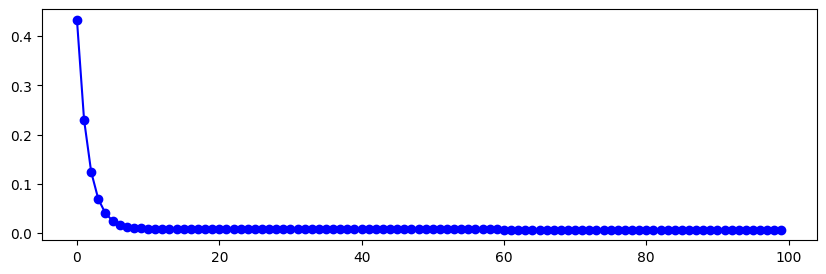

In [38]:
# ploting the results, loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
plt.plot(train_info['losses'], marker='o', color='blue')

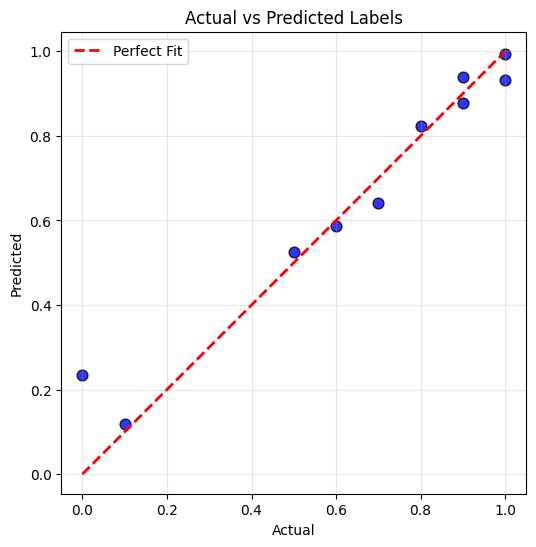

In [39]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, color='blue', edgecolor='k', s=60, alpha=0.8)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Labels')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()